# EDA RuSentiment
Ссылка на датасет: https://huggingface.co/datasets/MonoHime/ru_sentiment_dataset

Датасет содержит сообщения из социальных сетей с разметкой по тональности (положительная, отрицательная, нейтральная). Это хороший выбор, так как тексты из социальных сетей часто имеют особенности, которые важно учитывать при анализе тональности, например, сленг, сокращения и эмодзи.

Метки в датасете:
- 0: NEUTRAL
- 1: POSITIVE
- 2: NEGATIVE

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")
tqdm.pandas()

In [30]:
df = load_dataset("MonoHime/ru_sentiment_dataset")
df_train, df_test = df['train'].to_pandas(), df['validation'].to_pandas()

In [31]:
df_train.shape, df_test.shape

((189891, 3), (21098, 3))

In [32]:
df_train, df_test = (
    df_train.drop(['Unnamed: 0'], axis=1),
    df_test.drop(['Unnamed: 0'], axis=1)
)

In [33]:
# 0: NEUTRAL, 1: POSITIVE, 2: NEGATIVE
df_train.head()

,text,sentiment
0,".с.,и спросил его: о Посланник Аллаха!Ты пори...",1
1,Роднее всех родных Попала я в ГКБ №8 еще в дек...,1
2,Непорядочное отношение к своим работникам Рабо...,2
3,"). Отсутствуют нормативы, Госты и прочее, что ...",1
4,У меня машина в руках 5 лет и это п...,1


In [34]:
df_train['sentiment'] = df_train['sentiment'].map({0: 'Neutral', 1: 'Positive', 2: 'Negative'})
df_test['sentiment'] = df_test['sentiment'].map({0: 'Neutral', 1: 'Positive', 2: 'Negative'})

In [35]:
df_train.head()

,text,sentiment
0,".с.,и спросил его: о Посланник Аллаха!Ты пори...",Positive
1,Роднее всех родных Попала я в ГКБ №8 еще в дек...,Positive
2,Непорядочное отношение к своим работникам Рабо...,Negative
3,"). Отсутствуют нормативы, Госты и прочее, что ...",Positive
4,У меня машина в руках 5 лет и это п...,Positive


In [36]:
# несколько примеров

for i in df_train.sample(5, random_state=42)['text'].tolist():
  print(i, end='\n\n')

Не советую Самая плохая детская поликлиника № 31 в Москве из всех существующих на земном шаре. Врачей не хватает, грубые, адекватные врачи давно сбежали, на телефонные звонки не отвечают, дозвонится не возможно, лечить не умеют. 

Этим врачам надо работать в другом месте Папу по скорой привезли в больницу №50. Положили в 3-ю терапию, где врачами был поставлен диагноз острый лейкоз. С таким диагнозом они обязаны перевести пациента в специализированную больницу, но они этого не торопились делать, мотивируя тем, что в больницах по профилю мест нет. Никакого лечения не оказывали, только делали анализы. Было упущено драгоценное время. Через неделю у папы открылось кровотечение и его перевели в реанимацию, а через три дня мой папа умер. Равнодушное и безразличное отношение врачей к пациентам, в реанимации оставили умирать моего папу, врачи пользуются тем, что в реанимацию родственников не пускают, и нельзя проследить, какое лечение они оказывают, по всей вероятности, никакого. А врач-реанима

## Feature Engineering
Есть несколько эвристических признаков:
- длина текста
- средняя длина слова
- доля знаков пунктуации
- доля "!"
- доля "?"
- доля капсовых слов
- доля капсовых букв
- доля уникальных слов
- доля стоп-слов
- доля положительных слов
- доля отрицательных слов
- доля слов усилителей
- доля слов ослабителей
- доля матов в тексте

In [ ]:
import pymorphy2
import re
from functools import lru_cache

morph = pymorphy2.MorphAnalyzer()

In [37]:
stop_words = [
    # Местоимения (личные, притяжательные, указательные — без контекста бесполезны)
    "я", "ты", "он", "она", "оно", "мы", "вы", "они",
    "меня", "тебя", "его", "её", "нас", "вас", "их",
    "мне", "тебе", "ему", "ей", "нам", "вам", "им",
    "мной", "тобой", "им", "ней", "нами", "вами", "ими",
    "мой", "твой", "его", "её", "наш", "ваш", "их",
    "этот", "эта", "это", "эти",
    "тот", "та", "то", "те",
    "весь", "вся", "всё", "все",
    "сам", "сама", "само", "сами",
    "кто", "что", "какой", "какая", "какое", "какие",
    "чей", "чья", "чьё", "чьи",
    "который", "которая", "которое", "которые",

    # Предлоги (чисто грамматические)
    "в", "во", "на", "с", "со", "из", "от", "до", "у", "о", "об", "по", "за", "над", "под",
    "к", "ко", "перед", "через", "без", "для", "про", "при", "между", "около", "вокруг",
    "сквозь", "после", "против", "вдоль", "вблизи", "внутри", "снаружи", "напротив",
    "вслед", "вместо", "вне", "внутрь", "вверх", "вниз", "вперёд", "назад",

    # Союзы
    "и", "а", "но", "да", "или", "либо", "зато", "что", "чтобы", "как", "если", "когда",
    "пока", "потому", "хотя", "несмотря", "ли", "тоже", "также", "ни", "едва",

    # Частицы (чисто грамматические, не усиливающие/не ослабляющие)
    "не", "ни", "бы", "пусть", "давай", "давайте", "то", "либо", "нибудь", "ка",

    # Вспомогательные глаголы и связки
    "быть", "есть", "являться", "становиться", "делать", "сделать", "иметь", "мочь",
    "хотеть", "надо", "нужно", "следует", "стоит", "бывает"
]

In [38]:
positive_words = [
    # Эмоции и чувства
    "радость", "счастье", "восторг", "блаженство", "наслаждение", "удовольствие",
    "ликование", "восхищение", "вдохновение", "энтузиазм", "воодушевление",
    "улыбка", "смех", "веселье", "бодрость", "оптимизм", "надежда", "вера",
    "доверие", "любовь", "нежность", "забота", "доброта", "щедрость", "милосердие",
    "благодарность", "признательность", "уважение", "восхищение", "гордость",
    "успех", "триумф", "победа", "гармония", "спокойствие", "мир", "согласие",
    "свобода", "независимость", "достоинство", "честь", "благородство",

    # Положительные качества личности
    "добрый", "хороший", "честный", "отзывчивый", "внимательный", "заботливый",
    "преданный", "верный", "надёжный", "щедрый", "милосердный", "благородный",
    "вежливый", "тактичный", "скромный", "трудолюбивый", "настойчивый",
    "целеустремлённый", "ответственный", "умный", "талантливый", "креативный",
    "изобретательный", "инициативный", "энергичный", "активный", "бодрый",
    "здоровый", "сильный", "выносливый", "гибкий", "уравновешенный", "спокойный",
    "терпеливый", "дружелюбный", "открытый", "искренний", "прямолинейный",
    "чуткий", "эмпатичный", "гуманный", "гостеприимный", "обаятельный",
    "харизматичный", "обходительный", "предусмотрительный", "благоразумный",

    # Действия и глаголы
    "радоваться", "улыбаться", "смеяться", "веселиться", "наслаждаться",
    "восхищаться", "вдохновлять", "вдохновляться", "помогать", "поддерживать",
    "заботиться", "дарить", "делиться", "благодарить", "хвалить", "одобрять",
    "прощать", "обнимать", "любить", "уважать", "ценить", "доверять", "верить",
    "побеждать", "успевать", "преуспевать", "развиваться", "расти", "учиться",
    "творить", "создавать", "строить", "улучшать", "исправлять", "восстанавливать",
    "оживать", "ожидать", "надеяться", "мечтать", "стремиться", "достигать",
    "получать", "находить", "открывать", "радовать", "восстанавливать", "воскрешать",

    # Состояния и абстрактные понятия
    "благо", "добро", "красота", "истина", "справедливость", "гармония",
    "порядок", "ясность", "чистота", "свежесть", "лёгкость", "простота",
    "ясность", "понимание", "согласие", "единство", "согласованность", "созвучие",
    "процветание", "благоухание", "сияние", "свет", "тепло", "уют", "комфорт",
    "стабильность", "надёжность", "безопасность", "защищённость", "достаток",
    "изобилие", "плодородие", "рост", "расцвет", "возрождение", "оживление",

    # Наречия и усилители
    "прекрасно", "замечательно", "отлично", "чудесно", "восхитительно",
    "великолепно", "потрясающе", "фантастически", "безупречно", "идеально",
    "успешно", "гладко", "легко", "свободно", "радостно", "весело", "игриво",
    "нежно", "тепло", "искренне", "честно", "открыто", "щедро", "благородно",
    "мудро", "умело", "ловко", "мастерски", "профессионально", "уверенно",
    "спокойно", "уравновешенно", "терпеливо", "внимательно", "заботливо",

    # Дополнительные позитивные слова
    "солнце", "цветок", "весна", "рассвет", "звезда", "небо", "море", "луг",
    "праздник", "подарок", "сюрприз", "чудо", "волшебство", "сказка", "мечта",
    "план", "цель", "намерение", "желание", "стремление", "воля", "сила",
    "здоровье", "жизнь", "любимый", "дорогой", "близкий", "родной", "друг",
    "союз", "партнёрство", "сотрудничество", "поддержка", "помощь", "семья",
    "дом", "очаг", "мир", "тишина", "покой", "баланс", "равновесие", "ясность",
    "просветление", "озарение", "прозрение", "вдохновение", "муза", "талант",
    "гений", "дар", "способность", "возможность", "шанс", "удача", "везение",
    "благоприятный", "успешный", "плодотворный", "эффективный", "полезный",
    "ценный", "важный", "значимый", "нужный", "желанный", "ожидаемый", "радостный",

    # Общая оценка
    "отлично", "классно", "супер", "круто", "огонь", "топ", "бомба", "вау", "ух ты",
    "восхитительно", "замечательно", "прекрасно", "идеально", "безупречно", "фантастика",
    "лучше", "лучший", "надёжный", "качественный", "стильный", "современный", "удобный",

    # Эмоции и реакции
    "рад", "доволен", "в восторге", "восхищён", "впечатлён", "обрадован", "счастлив",
    "улыбается", "смеётся", "весело", "уютно", "тепло", "приятно", "комфортно", "легко",

    # Оценка сервиса/обслуживания
    "вежливый", "внимательный", "помогли", "поддержали", "быстро", "оперативно",
    "вовремя", "профессионально", "грамотно", "чётко", "ясно", "понятно", "дружелюбно",
    "приветливо", "обходительно", "заботливо", "ответили", "решили", "исправили",

    # Оценка товара/продукта
    "работает", "функционирует", "заряжается", "держит", "не глючит", "не тормозит",
    "яркий", "насыщенный", "вкусный", "ароматный", "сочный", "нежный", "мягкий", "лёгкий",
    "долговечный", "прочный", "надёжный", "эргономичный", "эстетичный", "красивый",

    # Доверие и рекомендации
    "доверяю", "рекомендую", "советую", "берите", "покупайте", "закажите", "попробуйте",
    "стоит", "выгодно", "дёшево", "недорого",

    # Удовлетворённость
    "подходит", "удобно", "практично", "полезно", "нужно", "важно", "ценю", "благодарю"
]

In [39]:
negative_words = [
    # Эмоции и состояния
    "грусть", "печаль", "тоска", "уныние", "отчаяние", "безысходность", "апатия",
    "депрессия", "страх", "ужас", "паника", "тревога", "волнение", "беспокойство",
    "раздражение", "злость", "ярость", "гнев", "ненависть", "злоба", "озлобленность",
    "обида", "разочарование", "неудовольствие", "недовольство", "досада", "досада",
    "стыд", "виноватость", "раскаяние", "сожаление", "зависть", "ревность",
    "подозрение", "недоверие", "цинизм", "пессимизм", "безверие", "отчуждение",
    "одиночество", "изоляция", "потеря", "горе", "беда", "несчастье", "бедствие",
    "катастрофа", "провал", "поражение", "неудача", "крах", "банкротство",

    # Негативные качества личности
    "злой", "жестокий", "бессердечный", "бездушный", "эгоистичный", "корыстный",
    "жадный", "алчный", "лживый", "обманщик", "коварный", "вероломный",
    "подлый", "низкий", "гадкий", "мерзкий", "грязный", "нечестный", "надменный",
    "высокомерный", "презрительный", "грубый", "хамский", "агрессивный",
    "вспыльчивый", "раздражительный", "нудный", "скучный", "ленивый", "бездельник",
    "трусливый", "робкий", "неуверенный", "замкнутый", "подозрительный",
    "мстительный", "злопамятный", "интриган", "лицемер", "фальшивый", "надутый",
    "вредный", "заносчивый", "самодовольный", "недоброжелательный", "враждебный",

    # Действия и глаголы
    "плакать", "страдать", "мучиться", "болеть", "ранить", "обижать", "оскорблять",
    "унижать", "презирать", "ненавидеть", "завидовать", "ревновать", "обманывать",
    "врать", "скрывать", "прятать", "подозревать", "бояться", "дрожать", "кричать",
    "ругаться", "ссориться", "воевать", "нападать", "уничтожать", "ломать", "портить",
    "губить", "вредить", "мешать", "мешать", "препятствовать", "саботировать",
    "отказывать", "лишать", "терять", "проваливать", "проигрывать", "падать",
    "разрушать", "разваливаться", "гнить", "портиться", "исчезать", "умирать",
    "задыхаться", "стонать", "вопить", "жаловаться", "ныть", "ворчать", "проклинать",

    # Состояния и абстракции
    "боль", "страдание", "мука", "пытка", "угнетение", "давление", "насилие",
    "тирания", "деспотизм", "несправедливость", "обман", "ложь", "фальшь",
    "лицемерие", "предательство", "измена", "клевета", "сплетня", "интрига",
    "хаос", "беспорядок", "разруха", "грязь", "тлен", "смерть", "гибель", "конец",
    "тупик", "безысходность", "пустота", "бессмысленность", "абсурд", "безумие",
    "безумие", "помешательство", "паранойя", "ненависть", "вражда", "конфликт",
    "война", "раздор", "неприязнь", "враждебность", "недоброжелательность",

    # Наречия и усилители негатива
    "ужасно", "кошмарно", "отвратительно", "мерзко", "гадко", "противно",
    "неприятно", "тошнотворно", "безобразно", "скверно", "дурно", "плохо",
    "неудачно", "бесполезно", "бессмысленно", "тщетно", "напрасно", "впустую",
    "безрезультатно", "неправильно", "ошибочно", "фальшиво", "лицемерно",
    "жестоко", "бессердечно", "грубо", "хамски", "агрессивно", "враждебно",

    # Дополнительные негативные слова
    "тень", "тьма", "ночь", "холод", "лед", "смерть", "болезнь", "рана", "кровь",
    "слеза", "крик", "стон", "плач", "вопль", "ужас", "кошмар", "призрак", "чудовище",
    "дьявол", "ад", "проклятие", "порок", "грех", "падение", "разврат", "алкоголь",
    "наркотик", "зависимость", "разлад", "разрыв", "развод", "изгнание", "изоляция",
    "тюрьма", "цепи", "рабство", "угнетение", "эксплуатация", "бедность", "нищета",
    "голод", "холод", "болезнь", "инвалидность", "старость", "забвение", "заброшенность",
    "забвение", "забытость", "беспомощность", "беззащитность", "уязвимость",
    "опасность", "угроза", "риск", "авария", "крушение", "пожар", "наводнение",
    "землетрясение", "эпидемия", "чума", "голод", "война", "террор", "насилие",

    # Общая оценка
    "ужасно", "кошмарно", "отвратительно", "мерзко", "паршиво", "фу",
    "разочарование", "провал", "фейк", "обман", "пустышка",

    # Эмоции и реакции
    "разочарован", "недоволен", "злился", "разозлился", "обиделся", "расстроился",
    "раздражает", "бесит", "надоело", "устал", "усталость", "апатия",

    # Проблемы с сервисом/обслуживанием
    "игнорируют", "молчат", "кинули", "кидают", "обманули",
    "задержали", "потеряли", "сломали", "испортили", "грубят",
    "хамят", "некомпетентные", "тупят", "перекладывают", "отфутболили",

    # Проблемы с товаром/продуктом
    "сломался", "глючит", "тормозит", "виснет", "разрядился",
    "воняет", "горький", "пресный", "сухой", "жёсткий", "неудобный",
    "тяжёлый", "громоздкий", "хлипкий", "дешёвка", "подделка",
    "царапает", "давит", "жмёт",

    # Финансовые претензии
    "дорого", "переплатил", "завысили", "надули", "обсчитали",

    # Недоверие и предостережения
    "мошенники", "ловушка", "развод"
]

In [40]:
intensifiers = [
    # Стандартные усилители
    "очень", "сильно", "крайне", "чрезвычайно", "невероятно", "безумно", "адски",
    "страшно", "ужасно", "дико", "бешено", "чертовски", "просто", "абсолютно",
    "полностью", "совершенно", "вполне", "целиком", "настоятельно", "исключительно",

    # Разговорные и интернет-усилители
    "прям", "прямиком", "вообще", "полностью", "до безумия", "до ужаса", "до дна",
    "всё-таки", "таки", "ещё", "ещё бы", "намного", "гораздо", "значительно",
    "в разы", "в сто раз", "в тысячу раз", "максимально", "супер", "ультра", "гипер",

    # Усилители положительной/отрицательной оценки (в зависимости от контекста)
    "идеально", "безупречно", "абсолютно", "фактически", "действительно", "в самом деле"
]

In [41]:
diminishers = [
    # Смягчители и ограничители
    "немного", "чуть", "чуть-чуть", "слегка", "легко", "едва", "едва-едва",
    "почти", "приблизительно", "примерно", "вроде", "как бы", "типа", "наверное",
    "возможно", "похоже", "кажется", "предположительно", "отчасти", "частично",
    "в какой-то степени", "в некоторой степени", "в меру", "умеренно", "достаточно",

    # Слова неуверенности и сомнения
    "скорее", "вряд ли", "вряд", "едва ли", "всё же", "всё-таки", "таки",
    "лишь", "только", "всего", "всего лишь", "просто", "в общем", "в целом",

    # Уменьшительно-ласкательные (в разговорной речи могут ослаблять серьёзность)
    "малость", "маленько", "чуток"
]

In [42]:
with open('data/bad_words.txt') as file:
    bad_words = file.readlines()
    bad_words = [word.strip() for word in bad_words]

In [43]:
# функция для лемматизации

@lru_cache(maxsize=1_000_000)
def lemmatize_word(word):
    """Приводит одно слово к его нормальной форме (лемме)."""
    parsed_word = morph.parse(word)
    
    # самый вероятный вариант.
    if parsed_word:
        return parsed_word[0].normal_form
    return word

In [44]:
# функции для вычисления признаков

def text_length(text: str, *args) -> int:
    return len(text)

def avg_word_length(text: str, *args) -> float:
    return np.mean([len(x) for x in text.split()]).item()

def punct_marks_ratio(text: str, *args) -> float:
    punct_count = sum(text.count(mark) for mark in ',.;:!?\"\'')
    total_count = len(text)
    return punct_count / (total_count + 1e-10)

def exclamation_ratio(text: str, *args) -> float:
    exclamation_count = text.count('!')
    total_count = len(text)
    return exclamation_count / (total_count + 1e-10)

def question_ratio(text: str, *args) -> float:
    question_count = text.count('?')
    total_count = len(text)
    return question_count / (total_count + 1e-10)

def caps_words_ratio(text: str, cleaned_text: str, *args) -> float:
    words = cleaned_text.split()
    caps_words_count = sum(word.isupper() for word in words)
    words_total_count = len(words)
    return caps_words_count / (words_total_count + 1e-10)

def caps_symbols_ratio(text: str, cleaned_text: str, *args) -> float:
    caps_symbols_count = sum(x.isupper() for x in cleaned_text)
    total_count = len(cleaned_text)
    return caps_symbols_count / (total_count + 1e-10)

def unique_words_ratio(text: str, cleaned_text: str, lemmatized_text: str) -> float:
    unique_words_count = len(set(lemmatized_text.split()))
    total_words_count = len(lemmatized_text.split())
    return unique_words_count / (total_words_count + 1e-10)

def stop_words_ratio(text: str, cleaned_text: str, lemmatized_text: str) -> float:
    stop_words_count = sum(word in stop_words for word in lemmatized_text.split())
    total_words_count = len(lemmatized_text.split())
    return stop_words_count / (total_words_count + 1e-10)

def positive_words_ratio(text: str, cleaned_text: str, lemmatized_text: str) -> float:
    positive_words_count = sum(word in positive_words for word in lemmatized_text.split())
    total_words_count = len(lemmatized_text.split())
    return positive_words_count / (total_words_count + 1e-10)

def negative_words_ratio(text: str, cleaned_text: str, lemmatized_text: str) -> float:
    negative_words_count = sum(word in negative_words for word in lemmatized_text.split())
    total_words_count = len(lemmatized_text.split())
    return negative_words_count / (total_words_count + 1e-10)

def intensifiers_ratio(text: str, cleaned_text: str, lemmatized_text: str) -> float:
    intensifier_words_count = sum(word in intensifiers for word in lemmatized_text.split())
    total_words_count = len(lemmatized_text.split())
    return intensifier_words_count / (total_words_count + 1e-10)

def diminishers_ratio(text: str, cleaned_text: str, lemmatized_text: str) -> float:
    diminisher_words_count = sum(word in diminishers for word in lemmatized_text.split())
    total_words_count = len(lemmatized_text.split())
    return diminisher_words_count / (total_words_count + 1e-10)

def bad_words_ratio(text: str, cleaned_text: str, lemmatized_text: str) -> float:
    bad_words_count = sum(word in bad_words for word in lemmatized_text.split())
    total_words_count = len(lemmatized_text.split())
    return bad_words_count / (total_words_count + 1e-10)

In [45]:
def prepare_features(df: pd.DataFrame) -> pd.DataFrame:
    """Вычисляет все эвристические признаки для датасета"""

    df = df.copy()
    
    features_functions = [
        ('text_length', text_length),
        ('avg_word_length', avg_word_length),
        ('punct_marks_ratio', punct_marks_ratio),
        ('exclamation_ratio', exclamation_ratio),
        ('question_ratio', question_ratio),
        ('caps_words_ratio', caps_words_ratio),
        ('caps_symbols_ratio', caps_symbols_ratio),
        ('stop_words_ratio', stop_words_ratio),
        ('unique_words_ratio', unique_words_ratio),
        ('positive_words_ratio', positive_words_ratio),
        ('negative_words_ratio', negative_words_ratio),
        ('intensifiers_ratio', intensifiers_ratio),
        ('diminishers_ratio', diminishers_ratio),
        ('bad_words_ratio', bad_words_ratio),
    ]

    features = [x[0] for x in features_functions]
    functions = [x[1] for x in features_functions]

    df['cleaned_text'] = df['text'].progress_apply(lambda text: re.sub(r'[^a-zA-Zа-яА-ЯёЁ0-9]', ' ', text))
    df['lemmatized_text'] = df['cleaned_text'].progress_apply(lambda text: ' '.join([lemmatize_word(word) for word in text.split()]))
    df[features] = df.progress_apply(
        lambda row: [func(row.text, row.cleaned_text, row.lemmatized_text) for func in functions],
        axis=1, result_type='expand'
    )

    return df

In [46]:
stop_words = set([lemmatize_word(word) for word in stop_words])
positive_words = set([lemmatize_word(word) for word in positive_words])
negative_words = set([lemmatize_word(word) for word in negative_words])
intensifiers = set([lemmatize_word(word) for word in intensifiers])
diminishers = set([lemmatize_word(word) for word in diminishers])
bad_words = set([lemmatize_word(word) for word in bad_words])

In [47]:
df_train = prepare_features(df_train)

100%|██████████| 189891/189891 [01:04<00:00, 2962.21it/s]


In [48]:
df_test = prepare_features(df_test)

100%|██████████| 21098/21098 [00:07<00:00, 2970.20it/s]


## Распределения
### Распределение признаков по классам
Проверим визуально, насколько различаются классы по данным признакам

In [49]:
feature_names = [
    'text_length', 'avg_word_length', 'punct_marks_ratio',
    'exclamation_ratio', 'question_ratio', 'caps_words_ratio',
    'caps_symbols_ratio', 'stop_words_ratio', 'unique_words_ratio',
    'positive_words_ratio', 'negative_words_ratio', 'intensifiers_ratio',
    'diminishers_ratio', 'bad_words_ratio',
]

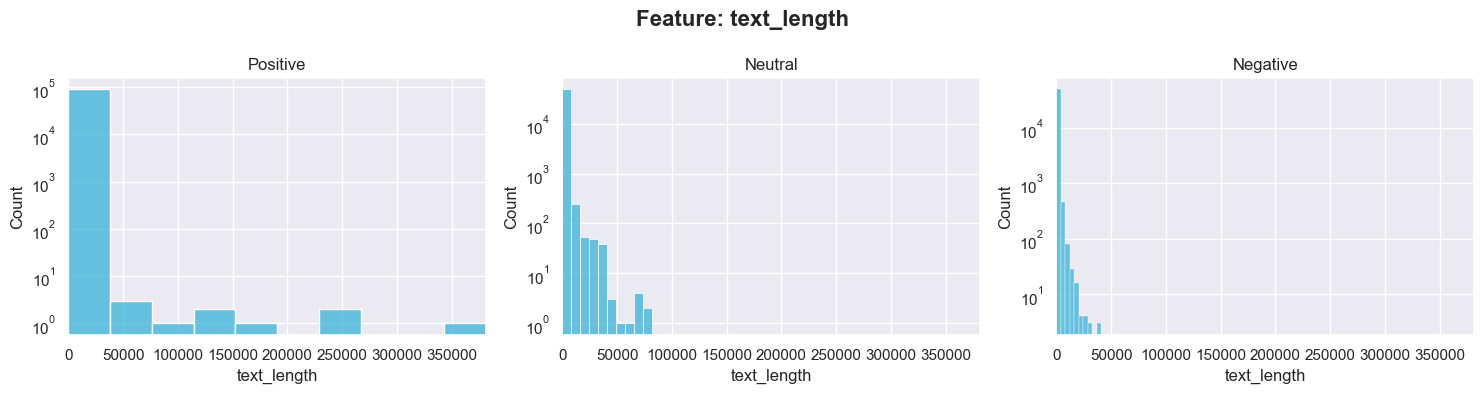

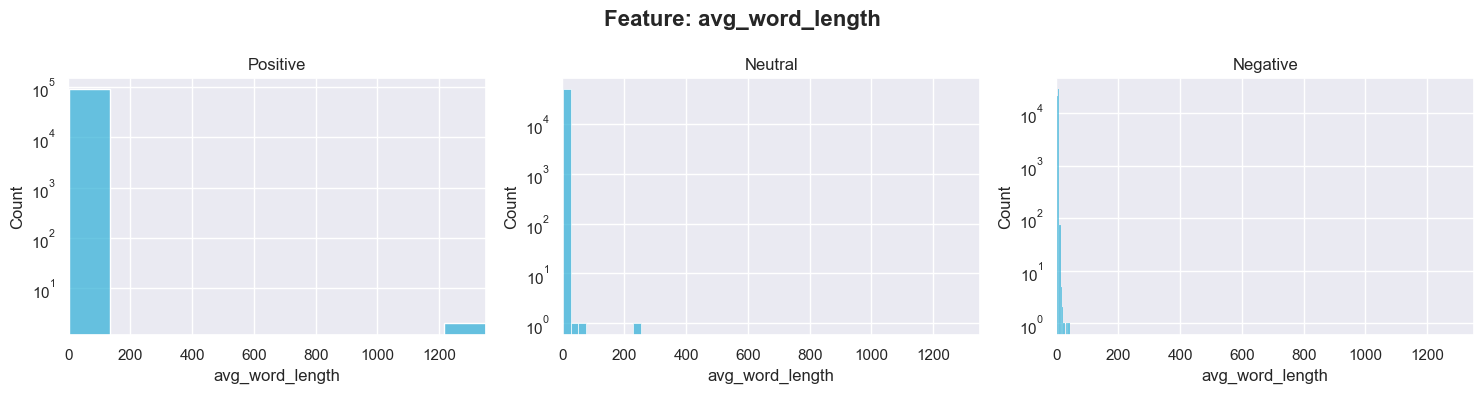

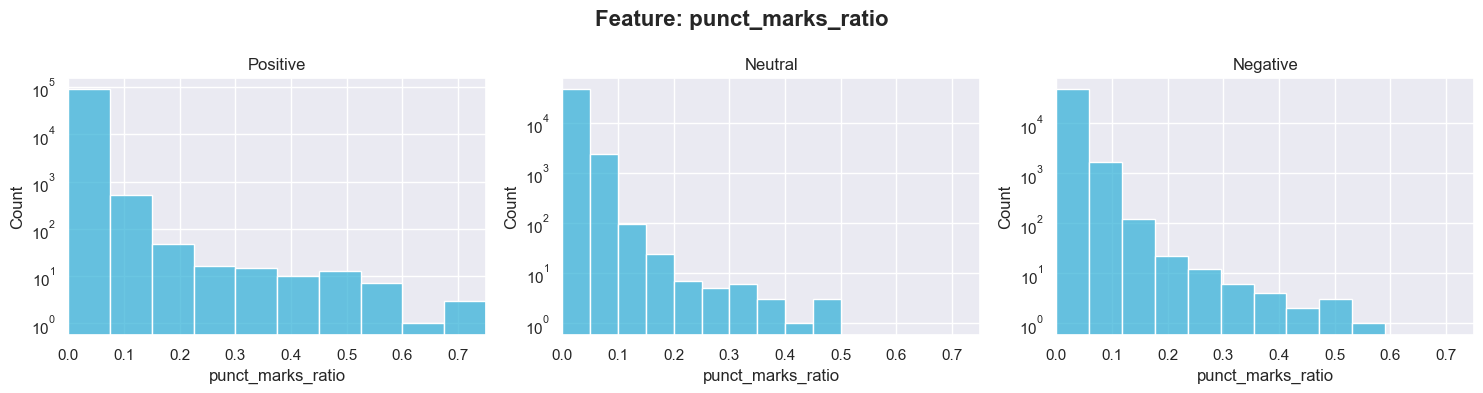

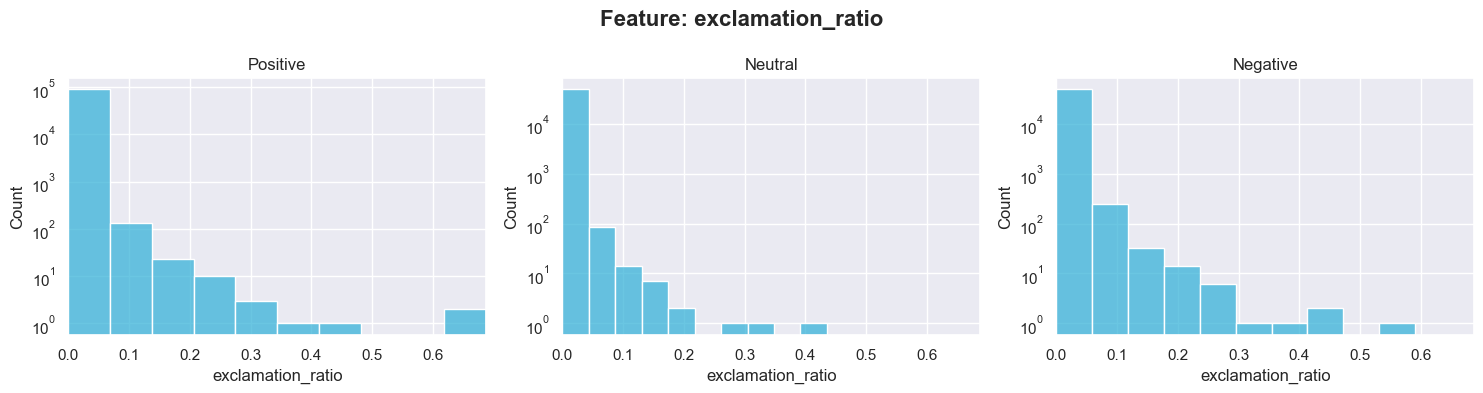

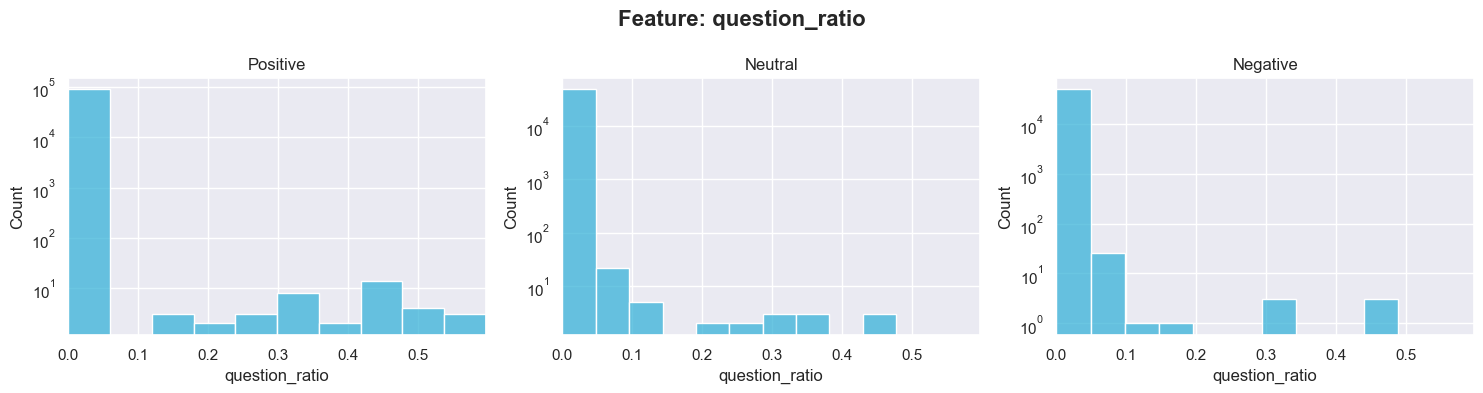

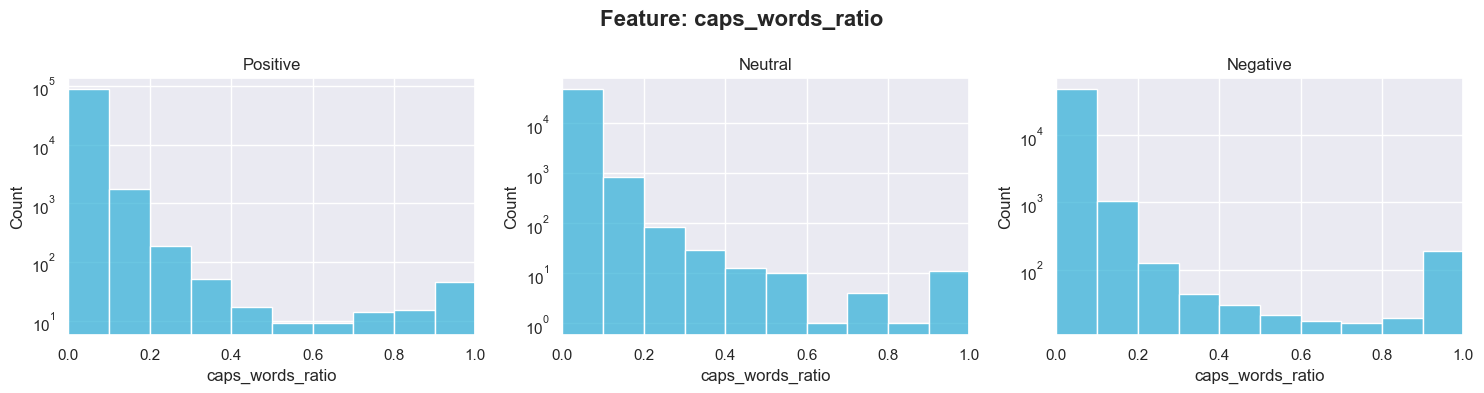

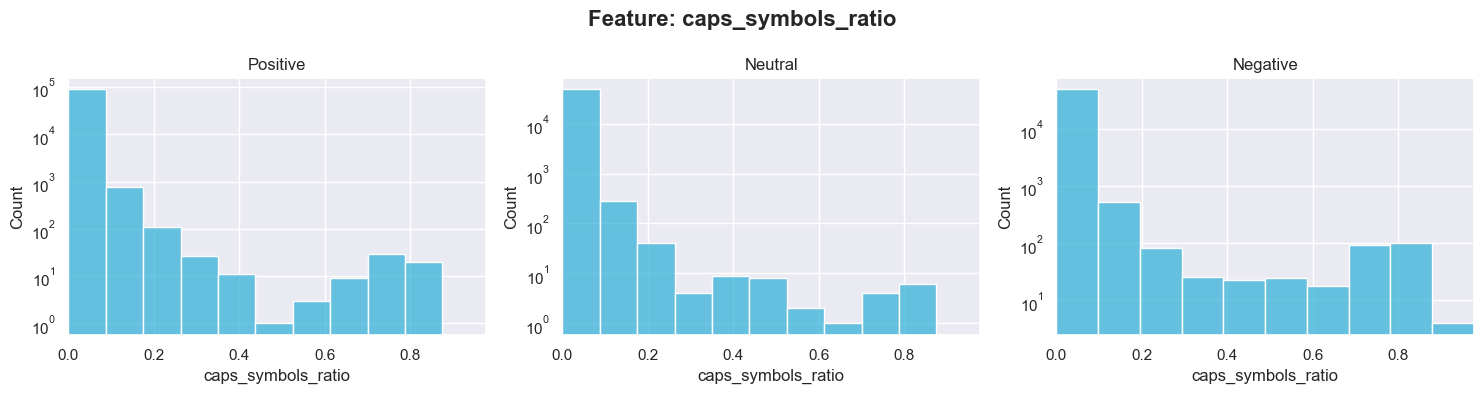

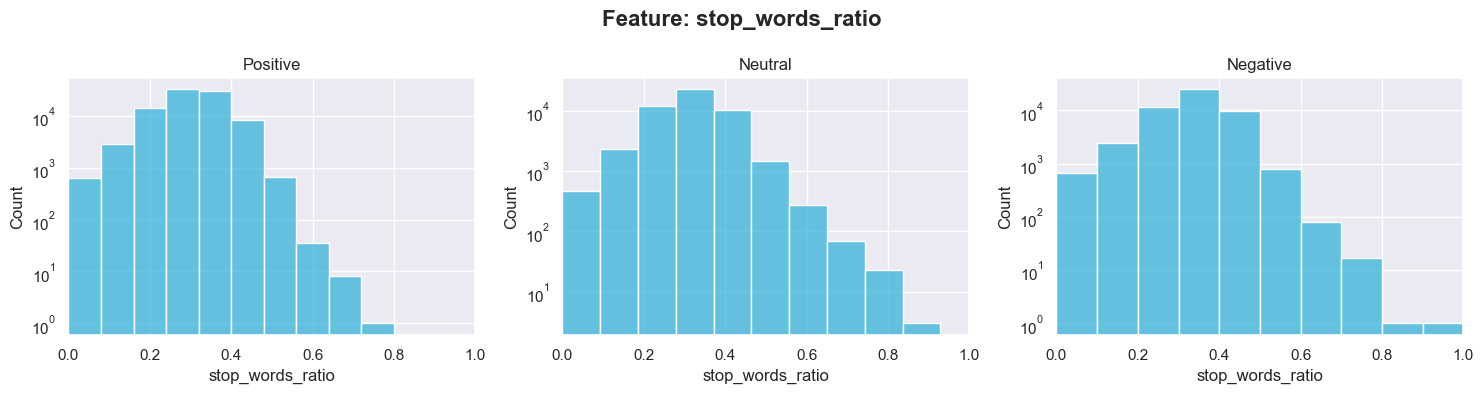

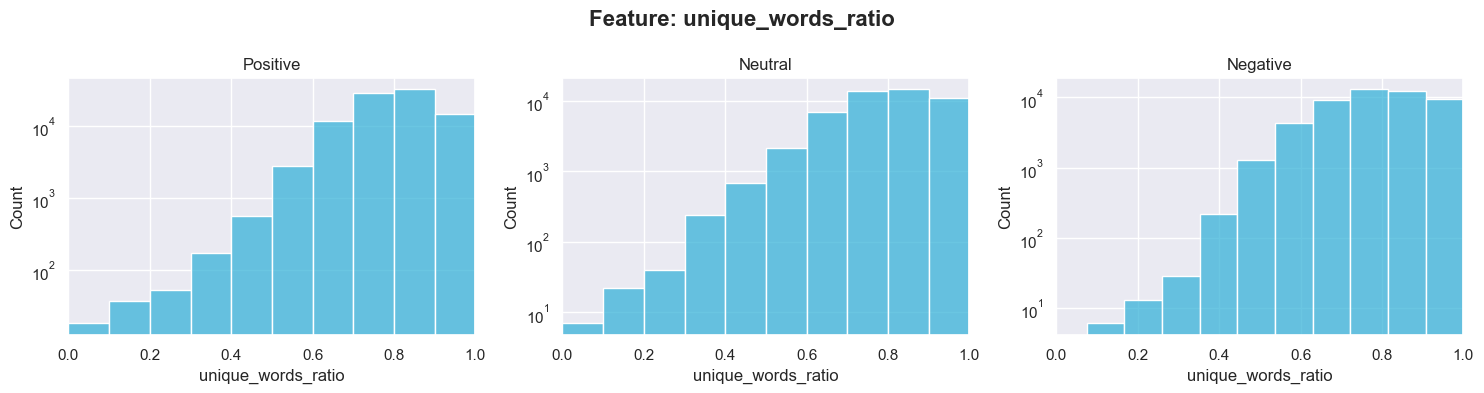

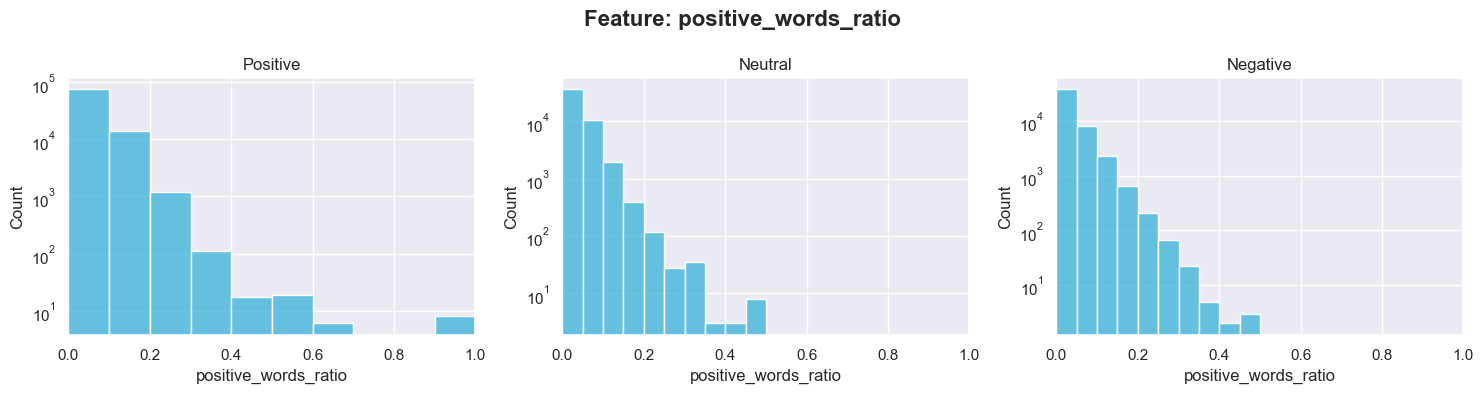

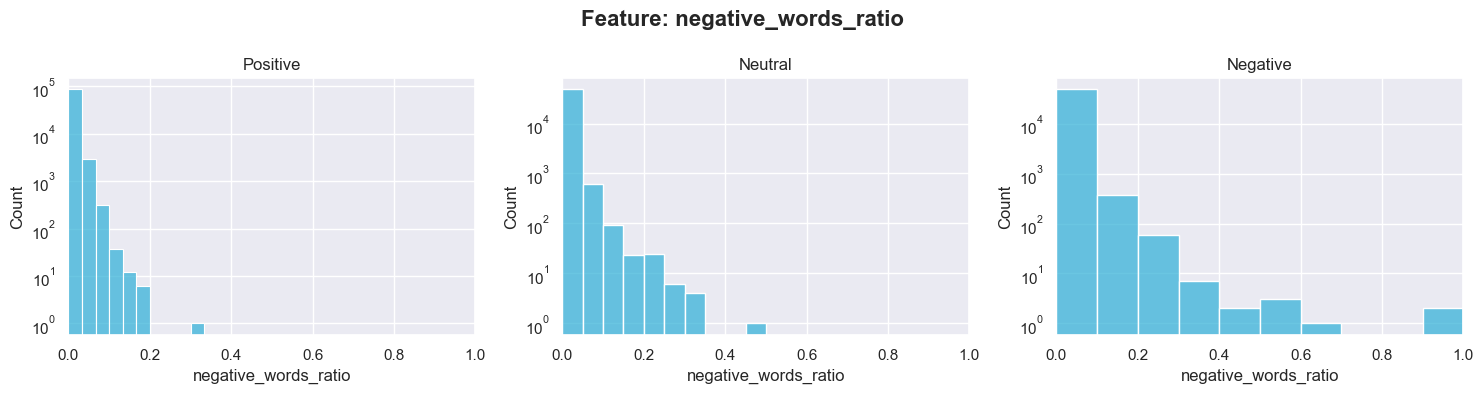

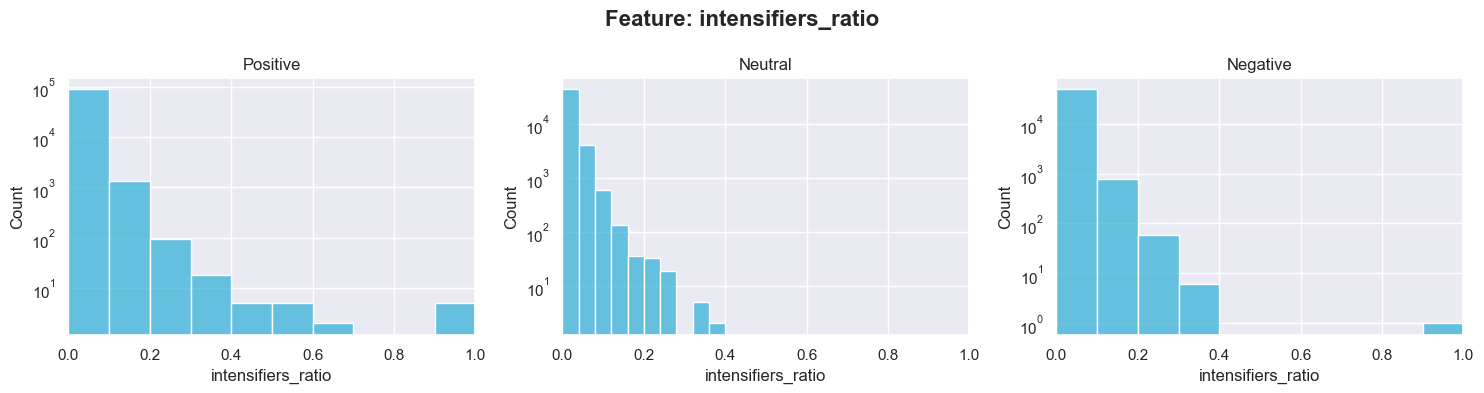

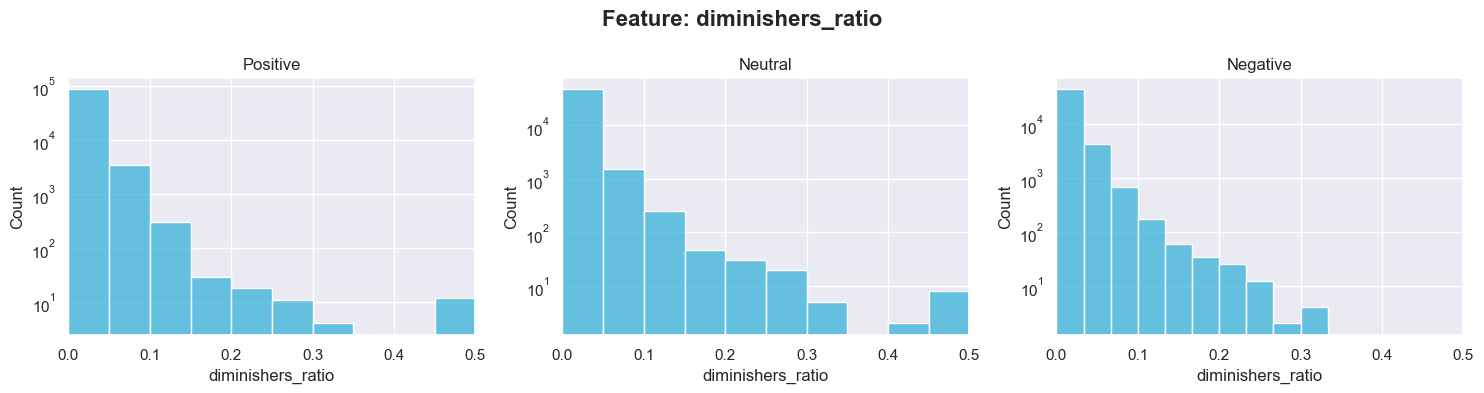

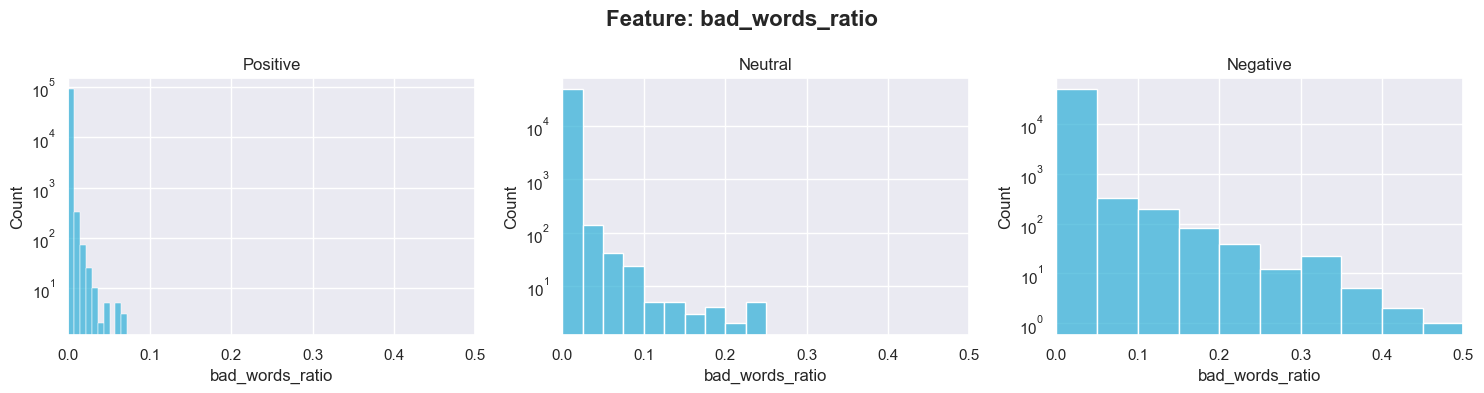

In [50]:
for feature in feature_names:
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    fig.suptitle(f'Feature: {feature}', fontsize=16, fontweight='bold')
    
    axs[0].set_xlim(0, df_train[feature].max())
    axs[1].set_xlim(0, df_train[feature].max())
    axs[2].set_xlim(0, df_train[feature].max())
    
    sns.histplot(df_train.loc[df_train['sentiment'] == 'Positive', feature], bins=10, color='#38b3d9', log=True, ax=axs[0])
    sns.histplot(df_train.loc[df_train['sentiment'] == 'Neutral', feature], bins=10, color='#38b3d9', log=True, ax=axs[1])
    sns.histplot(df_train.loc[df_train['sentiment'] == 'Negative', feature], bins=10, color='#38b3d9', log=True, ax=axs[2])
    
    axs[0].set_title('Positive')
    axs[1].set_title('Neutral')
    axs[2].set_title('Negative')

    plt.tight_layout()
    plt.show()

Кажется, что некоторые признаки могут помочь в разделении классов.

### Баланс классов

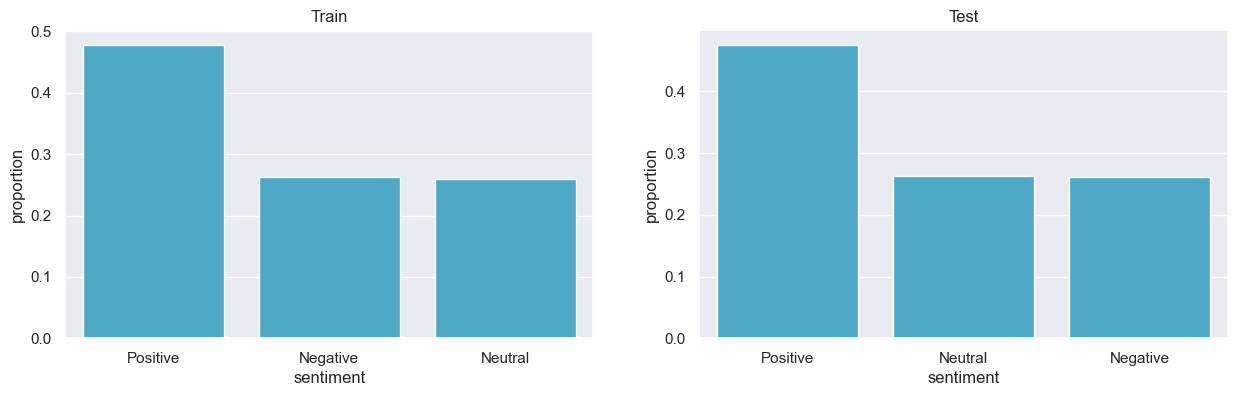

In [51]:
fix, axs = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(df_train['sentiment'].value_counts(normalize=True), color='#38b3d9', ax=axs[0])
sns.barplot(df_test['sentiment'].value_counts(normalize=True), color='#38b3d9', ax=axs[1])

axs[0].set_title('Train')
axs[1].set_title('Test')

plt.show()